In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")

from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import my_data
from utils.dice_score import dice_loss
from evaluate import evaluate
from unet import UNet
from predict import predict_img
import seaborn as sns
import pickle as pkl
from evaluate import aq_cost_function
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [6]:
results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]

In [7]:
results.experiment_name.unique()

array(['Aq5'], dtype=object)

In [8]:
results = results[results.experiment_name == "Aq5"]

In [9]:
results.columns

Index(['file_name', 'epochs', 'batch_size', 'cost_function',
       'init_train_ratio', 'experiment_name', 'lr', 'image_size', 'offset',
       'seed', 'scale', 'val', 'amp', 'add_step', 'bilinear', 'classes',
       'val_scores', 'best_val_score'],
      dtype='object')

In [10]:
results[['experiment_name','best_val_score', 'cost_function']].groupby('cost_function').mean()

,best_val_score
cost_function,
Mean,0.97
Random,0.96


In [11]:
results[['experiment_name','best_val_score', 'cost_function']]

,experiment_name,best_val_score,cost_function
0,Aq5,0.97,Mean
1,Aq5,0.96,Mean
2,Aq5,0.97,Mean
3,Aq5,0.96,Random
4,Aq5,0.97,Mean
5,Aq5,0.96,Mean
6,Aq5,0.96,Random
7,Aq5,0.95,Random
8,Aq5,0.96,Random
9,Aq5,0.97,Random


In [12]:
results = results.reset_index()

In [14]:
best_idx = results.best_val_score.argmax()

In [15]:
best_idx =0

In [16]:
len(results)

20

In [17]:
net = UNet(1, 3, bilinear = results.bilinear[best_idx]).to(device)

In [18]:

# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[best_idx]+".pt")))
net = net.to(device).eval()

In [19]:
img_list = my_data.load_dummy_data(data_path)


(6, 2048, 2048)
(6, 2048, 2048)


In [66]:
testout = aq_cost_function(net, device, img_list[:2,0])

In [67]:
testout.shape

torch.Size([1, 3, 1024, 1024])

In [28]:
(-(testout *np.log(testout))).mean()

C:\Users\lauri\AppData\Local\Temp\ipykernel_18836\759895011.py:1: RuntimeWarning: invalid value encountered in log
  (-(testout *np.log(testout))).mean()


nan

In [40]:
testout.shape

torch.Size([1, 3, 1024, 1024])

In [45]:
softmax =torch.softmax(testout[0], axis=0)


In [73]:
torch.quantile((logsoftmax(testout[0])*torch.softmax(testout[0], axis=0)).reshape(-1),.5)

tensor(-0.)

In [68]:
(logsoftmax(testout[0])*torch.softmax(testout[0], axis=0)).mean().item()

-3.2710130177387997e-13

In [48]:
softmax

tensor([[[1.6739e-17, 9.1032e-21, 2.5478e-23,  ..., 3.9367e-19,
          5.4596e-17, 5.4474e-08],
         [1.5523e-28, 4.3990e-39, 2.3822e-44,  ..., 2.7980e-36,
          6.8798e-32, 4.2438e-17],
         [3.7301e-33, 0.0000e+00, 0.0000e+00,  ..., 1.3187e-40,
          4.2037e-33, 3.5010e-15],
         ...,
         [2.5280e-32, 1.8777e-43, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.2061e-28],
         [1.5628e-26, 2.0294e-40, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 1.3085e-26],
         [1.8316e-17, 9.4319e-29, 2.5379e-29,  ..., 4.2039e-44,
          1.2762e-29, 5.9561e-11]],

        [[1.9763e-27, 1.1902e-39, 0.0000e+00,  ..., 2.2441e-37,
          1.2086e-30, 8.3472e-20],
         [3.0365e-41, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 4.3499e-31],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 4.9294e-35],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.000

In [47]:
torch.log(softmax) 

tensor([[[ -38.6288,  -46.1457,  -52.0242,  ...,  -42.3788,  -37.4466,
           -16.7255],
         [ -64.0327,  -88.3194, -100.4457,  ...,  -81.8642,  -71.7541,
           -37.6985],
         [ -74.6689,      -inf,      -inf,  ...,  -91.8268,  -74.5493,
           -33.2857],
         ...,
         [ -72.7553,  -98.3811,      -inf,  ...,      -inf,      -inf,
           -63.3073],
         [ -59.4207,  -91.3957,      -inf,  ...,      -inf,      -inf,
           -59.5983],
         [ -38.5387,  -64.5309,  -65.8436,  ...,  -99.8777,  -66.5311,
           -23.5440]],

        [[ -61.4886,  -89.6267,      -inf,  ...,  -84.3873,  -68.8881,
           -43.9298],
         [ -93.2953,      -inf,      -inf,  ...,      -inf,      -inf,
           -69.9100],
         [     -inf,      -inf,      -inf,  ...,      -inf,      -inf,
           -78.9953],
         ...,
         [     -inf,      -inf,      -inf,  ...,      -inf,      -inf,
               -inf],
         [ -95.1173,      -inf,      -in

In [46]:
(torch.log(softmax) * softmax).

torch.Size([3, 1024, 1024])

In [30]:
testout.min()

-250.46043

In [21]:
img_list[:,0]

(24, 2, 1024, 1024)

In [20]:
np.unique(img_list[:,1])

array([  2,  67, 224], dtype=uint8)

In [173]:
test = my_data.make_dataset(img_list,img_size=128, offset=64)
test[1].shape

(24, 2, 1024, 1024)


(5400, 128, 128)

In [178]:
img_idx = -4
test_img_np  = ((img_list[img_idx,0][None, None, ].astype(np.float32) -my_data.mean)/my_data.std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


(array([  1977.,  18170.,  22426.,  27885.,  41711., 100668., 329584.,
        408194.,  91213.,   6748.]),
 array([0.004283  , 0.38241613, 0.76054925, 1.1386824 , 1.5168155 ,
        1.8949486 , 2.2730818 , 2.6512148 , 3.029348  , 3.4074812 ,
        3.7856143 ], dtype=float32),
 <BarContainer object of 10 artists>)

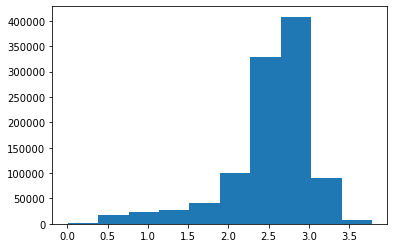

In [186]:
plt.hist(output.max(axis=0).reshape(-1))

In [181]:
show_img = np.zeros_like(img_list[img_idx, 1])
show_img[np.where(img_list[img_idx, 1] ==my_data.phase_1)] =1
show_img[np.where(img_list[img_idx, 1] ==my_data.phase_2)] =2

In [182]:
 output.max(axis=0).mean()

2.4954588

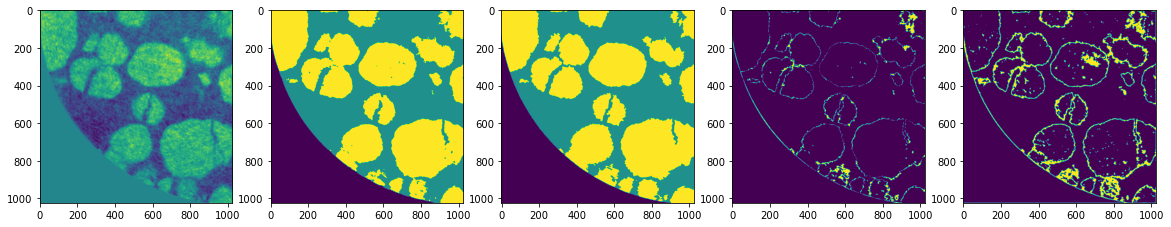

In [183]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,5))
axes[0].imshow(img_list[img_idx,0])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [129]:
err_img[np.where(std_large)].mean()

0.7212325239848175

In [130]:
err_img[np.where(1-std_large)].mean()

0.9938201878103416

In [159]:
correct_plot = (show_img ==np.argmax(output, axis=0) ).reshape(-1)
std_plot = std_large.reshape(-1)

In [62]:
std_plot

array([ True,  True,  True, ...,  True,  True,  True])

In [69]:
output.max(axis=0)[np.where(show_img ==np.argmax(output, axis=0) )].mean()

1.8058479

In [70]:
output.max(axis=0)[np.where(show_img !=np.argmax(output, axis=0) )].mean()

1.3284773

In [48]:
correct_plot.mean()

0.9855046272277832

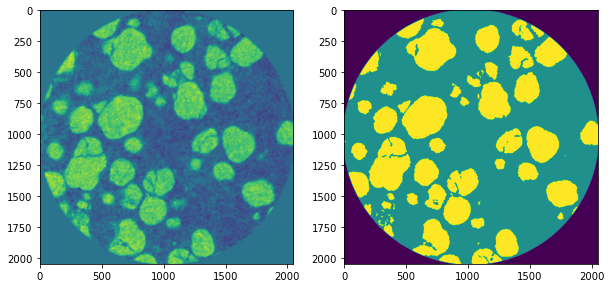

In [21]:

fig, axes = plt.subplots(ncols = 2, figsize = (10,5))
axes[0].imshow(img_list[0][img_idx,])
axes[1].imshow(show_img)
